# __Projektarbeit - Peach Purees__
## *Felix Romer*

![jdj](11pfirsich.jpg)

***
## Structure
1. [Import](#import) 
2. [Extract relevant information](#extract-relevant-information)
3. [Preprocessing of spectral data](#preprocessing-of-spectral-data)
4. [PCA](#pca)
5. [PCA-R](#pca-r)
6. [PLS](#pls)

## Import
### Package-Import

In [44]:
#Basics
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#PCA
from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler, normalize

#Preprocessing
from scipy.signal import savgol_filter

#Regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

#Hilfsskripte
from Preprocessing_aux import *
from plotfunctions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Import and Cleaning

In [45]:
#Read the File
file = 'Data_5.csv'
df = pd.read_csv(file)

#Generating Wavenumber
delta_Wavenumber= ((2000-780)/599)
Wavenumber = np.array(list(map(lambda num: round(num, 2), (np.arange(780, (2000 + delta_Wavenumber), delta_Wavenumber)))))

df.columns.values[1:601] = Wavenumber

display(df.head(2))
df.shape

,Brix,780.0,782.04,784.07,786.11,788.15,790.18,792.22,794.26,796.29,...,1981.67,1983.71,1985.74,1987.78,1989.82,1991.85,1993.89,1995.93,1997.96,2000.0
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692447,0.692944,0.692376,0.690764,0.688081,0.684294,0.679348,0.67324,0.665922,0.657307
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.729328,0.728031,0.725548,0.721815,0.716767,0.710405,0.702706,0.69371,0.683480,0.671960


(50, 601)

## Extract relevant information

In [46]:
#Brix-Inforamtion
Brix_ = pd.DataFrame(df.iloc[:,0])

#Spectral data
Spektrum = df.iloc[:,1:].values.astype(np.float64)

#Wavenumbers
Wavenumber

array([ 780.  ,  782.04,  784.07,  786.11,  788.15,  790.18,  792.22,
        794.26,  796.29,  798.33,  800.37,  802.4 ,  804.44,  806.48,
        808.51,  810.55,  812.59,  814.62,  816.66,  818.7 ,  820.73,
        822.77,  824.81,  826.84,  828.88,  830.92,  832.95,  834.99,
        837.03,  839.07,  841.1 ,  843.14,  845.18,  847.21,  849.25,
        851.29,  853.32,  855.36,  857.4 ,  859.43,  861.47,  863.51,
        865.54,  867.58,  869.62,  871.65,  873.69,  875.73,  877.76,
        879.8 ,  881.84,  883.87,  885.91,  887.95,  889.98,  892.02,
        894.06,  896.09,  898.13,  900.17,  902.2 ,  904.24,  906.28,
        908.31,  910.35,  912.39,  914.42,  916.46,  918.5 ,  920.53,
        922.57,  924.61,  926.64,  928.68,  930.72,  932.75,  934.79,
        936.83,  938.86,  940.9 ,  942.94,  944.97,  947.01,  949.05,
        951.09,  953.12,  955.16,  957.2 ,  959.23,  961.27,  963.31,
        965.34,  967.38,  969.42,  971.45,  973.49,  975.53,  977.56,
        979.6 ,  981

### Brix distribution

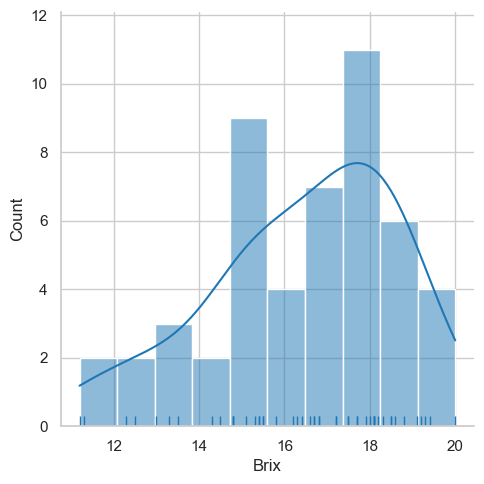

In [47]:
sns.displot(df['Brix'], kde=True, bins=10, rug=True)
plt.show()

-> There are more samples for large Brix values than for small ones.
<br><br>

## Preprocessing of spectral data

In [48]:
#Multiplicative Scatter Correction
X_msc = msc(Spektrum)

#Rubberband Baseline Correction
X_rub = rubberband(X_msc, Wavenumber)

#Vetor Normalization
X_norm= normalize(X_rub)

#Second Multiplicative Scatter Correction
X_pre = msc(X_norm)

# Savitzky-Golay Smoothing
w = 15 
p = 2 
X_prepro = savgol_filter(X_pre, w, polyorder = p, deriv=0)
X_prepro_abl1 = savgol_filter(X_pre, w, polyorder = p, deriv=1)
X_prepro_abl2 = savgol_filter(X_pre, w, polyorder = p, deriv=2)

### Influence of preprocessing on the spectral data - a visual illustration

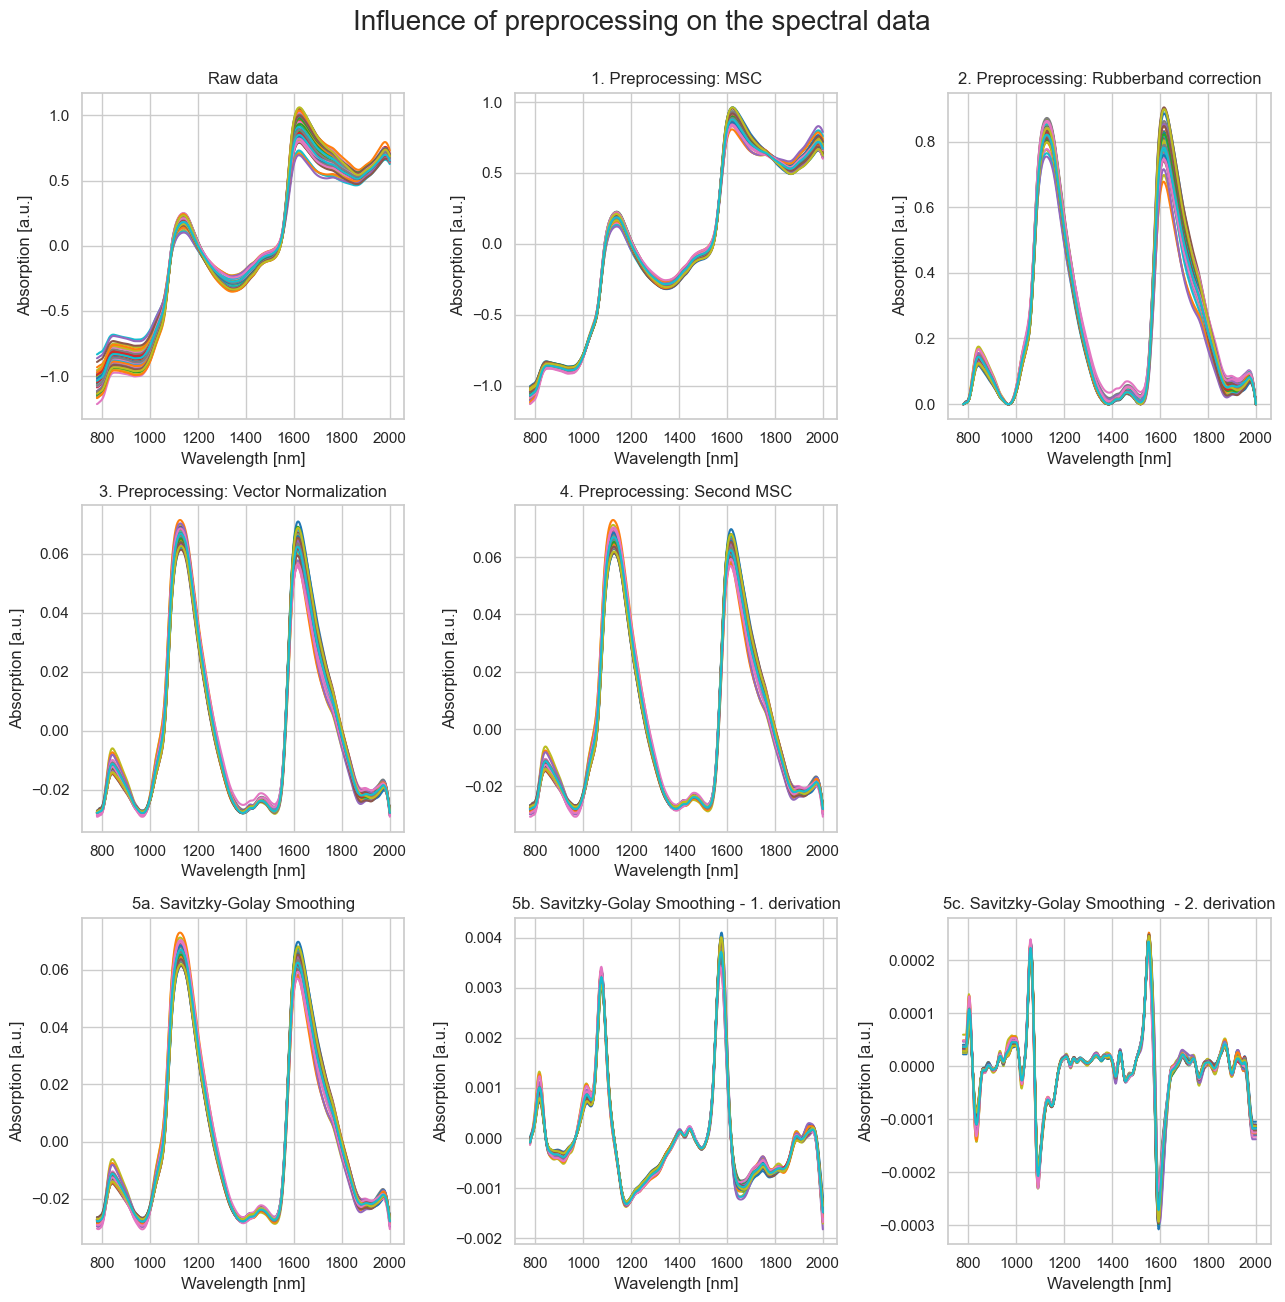

In [49]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(13,13))

plotspec(Spektrum, Wavenumber, 'Raw data', ax=ax1)

plotspec(X_msc, Wavenumber, '1. Preprocessing: MSC', ax=ax2)

plotspec(X_rub, Wavenumber, '2. Preprocessing: Rubberband correction', ax=ax3)

plotspec(X_norm, Wavenumber, '3. Preprocessing: Vector Normalization', ax=ax4)

plotspec(X_pre, Wavenumber, '4. Preprocessing: Second MSC', ax=ax5)

plotspec(X_prepro, Wavenumber, '5a. Savitzky-Golay Smoothing', ax=ax7)

plotspec(X_prepro_abl1, Wavenumber, '5b. Savitzky-Golay Smoothing - 1. derivation', ax=ax8)

plotspec(X_prepro_abl2, Wavenumber, '5c. Savitzky-Golay Smoothing  - 2. derivation', ax=ax9)
fig.delaxes(ax6)
plt.suptitle('Influence of preprocessing on the spectral data', y=1.0, fontsize=20)
fig.tight_layout()

## PCA

Best separation was achieved after Savitzky-Golay smoothing with the first derivative and scaling:

In [50]:
#PCA Initialization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_prepro_abl1)

PCA = sk_pca(n_components=10)
pca = PCA.fit(X_scaled)

#Loadings
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns = ('PC' + str(i) for i in np.arange(1,11))) 
loadings_df['variable'] = Wavenumber
loadings_df = loadings_df.set_index('variable')

#scores
scores = pca.transform(X_scaled)
scores_df = pd.DataFrame(scores, columns= ('PC' + str(i) for i in np.arange(1,11)))

#Modification of scores_df for the following visualisations

scores_df['Brix']=Brix_['Brix']

### Scree Plot and TSQ Plot

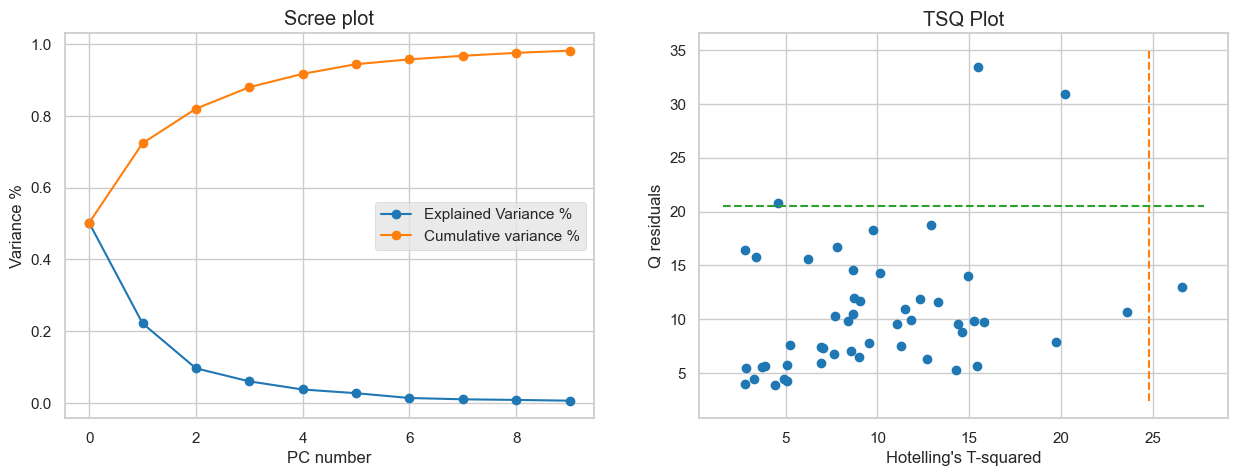

In [55]:
fig,(ax1, ax2)=plt.subplots(ncols=2, figsize=(15,5))
scree_plot(pca, ax=ax1)
tsg=Tsq_Q_plot(X_scaled, scores, loadings, ax=ax2)
plt.show()

### Scores Plot

#### Matrixplot

<Figure size 7680x5760 with 0 Axes>

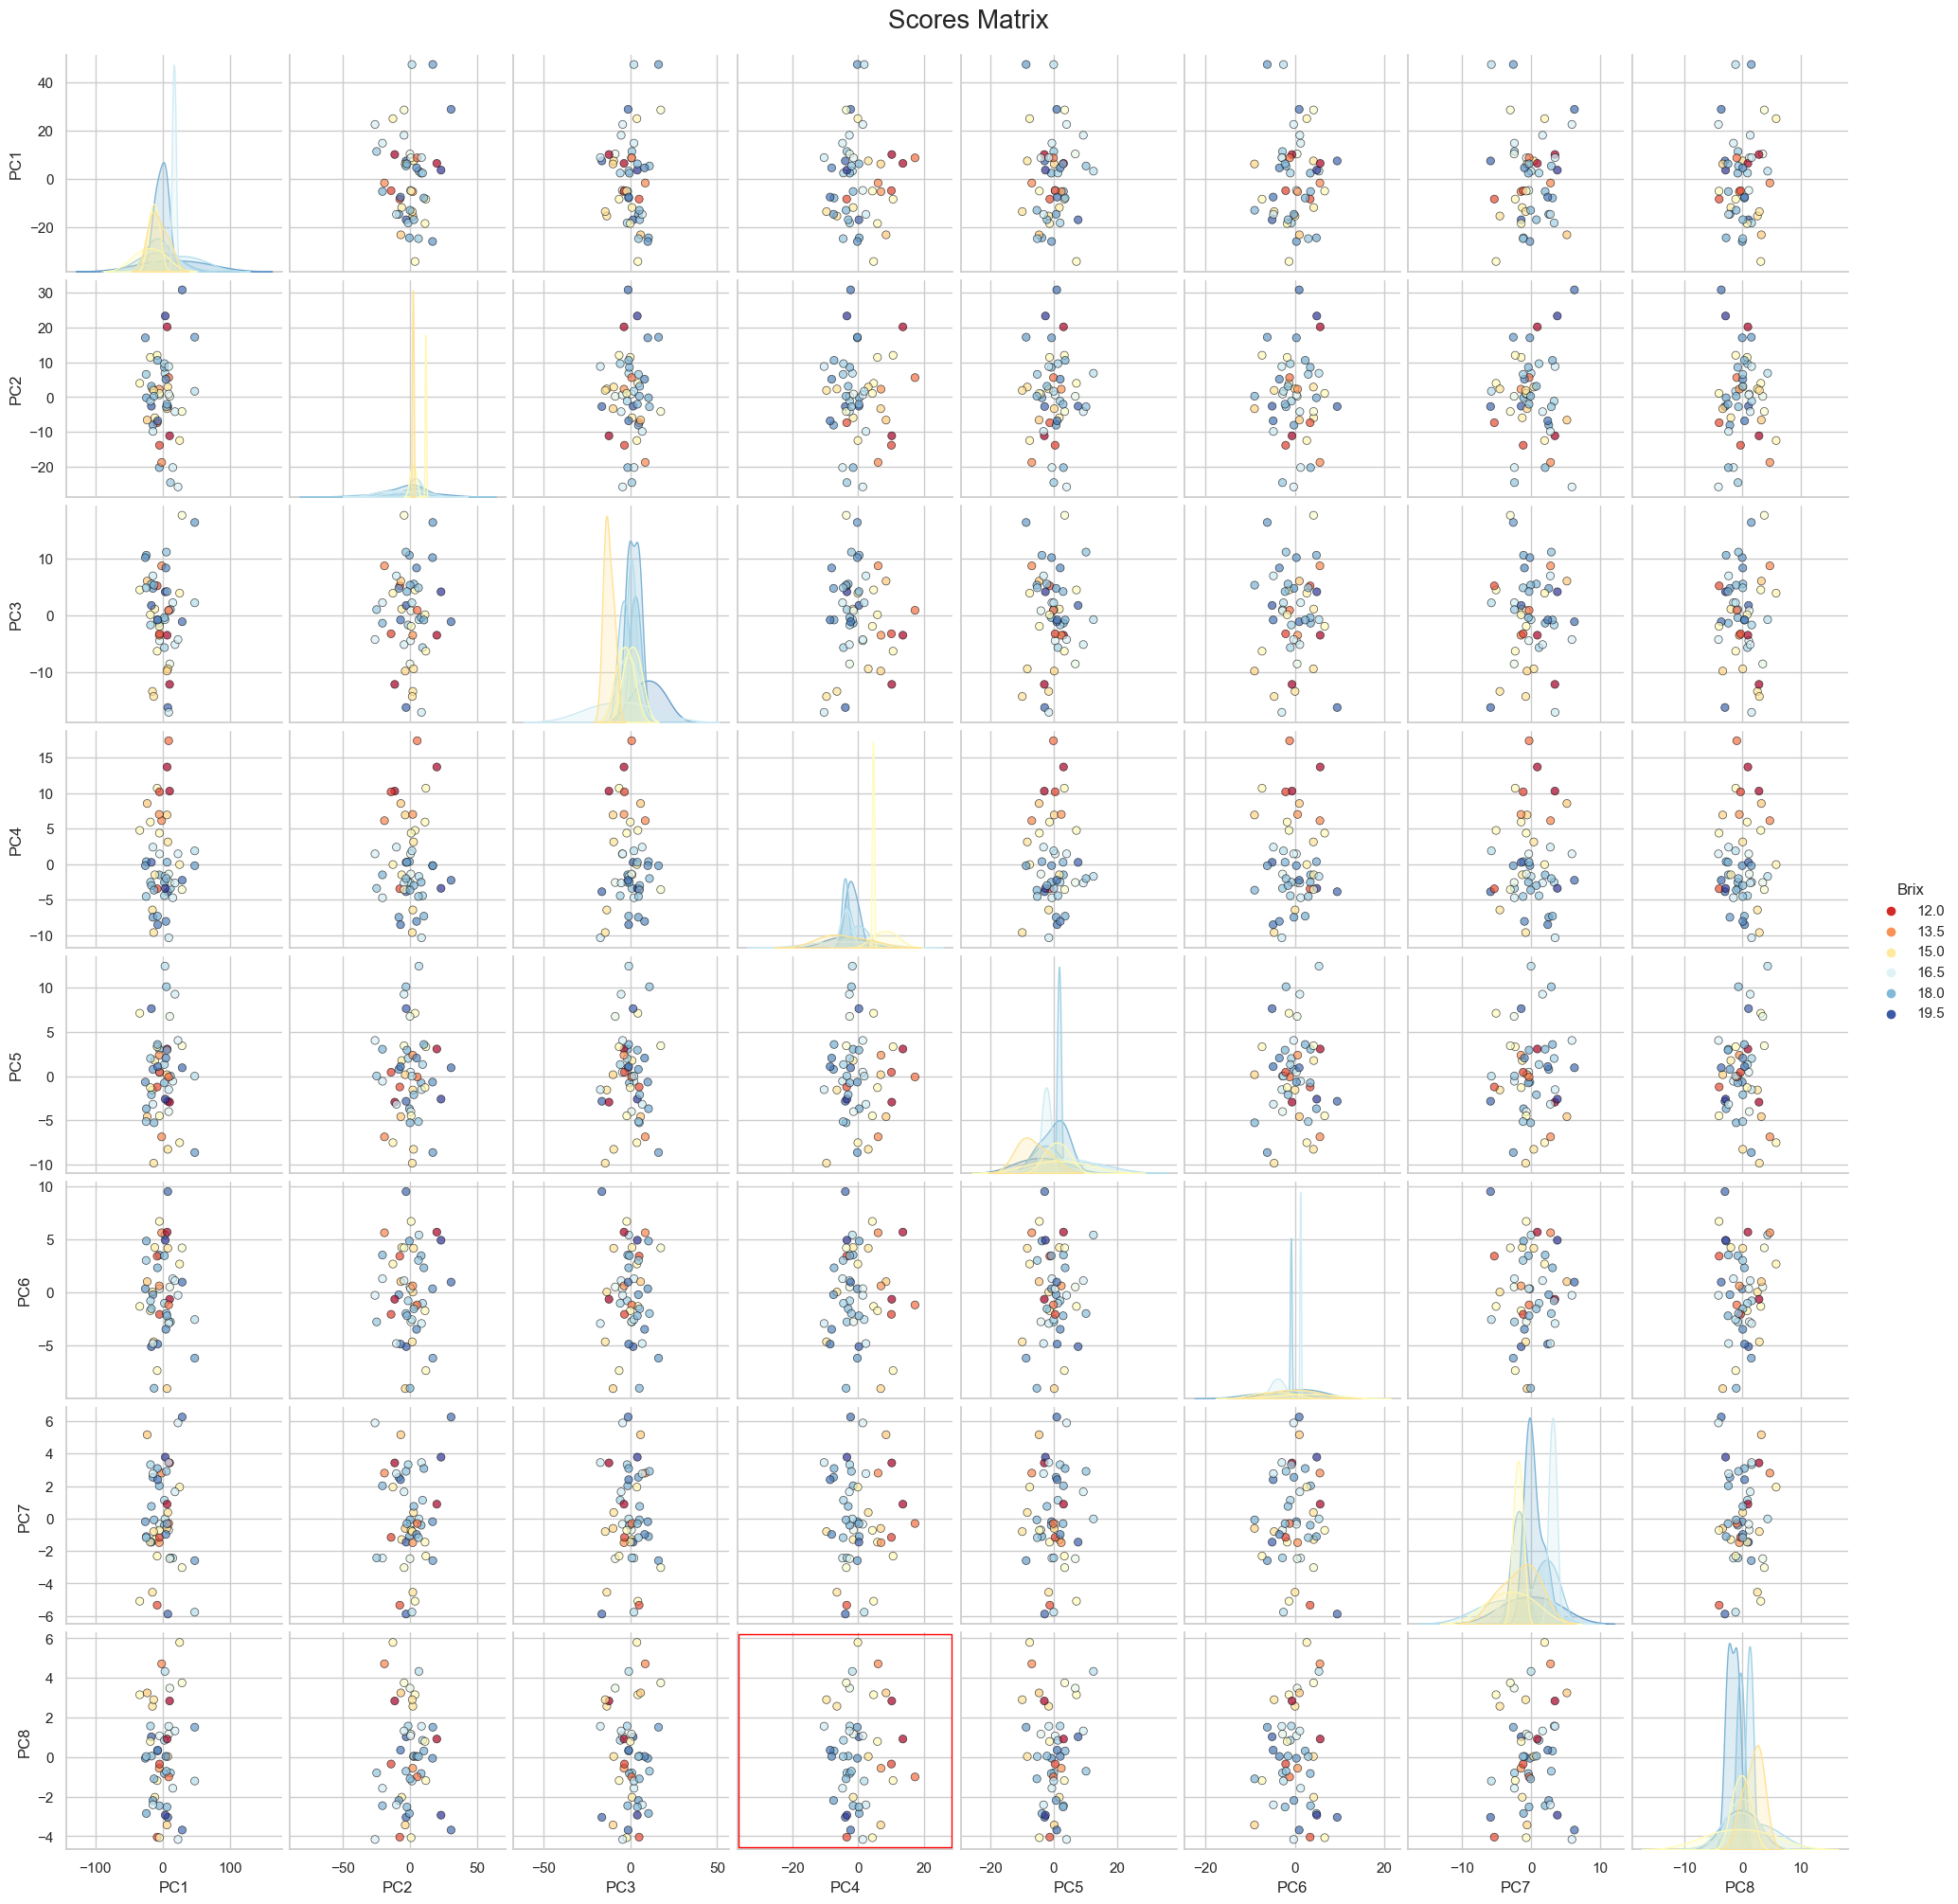

In [61]:
plt.figure(dpi=1200)
sns.set_style('whitegrid')
sns.set_context('notebook')


g=sns.pairplot(scores_df, vars=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'], hue='Brix',
                palette = 'RdYlBu', plot_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.7))
g.fig.suptitle('Scores Matrix', y=1.01, fontsize=20)
g.fig.patches.extend([plt.Rectangle((0.52,0.12),0.15,0.45,
                                  fill=False, color='r', 
                                  transform=fig.transFigure, figure=fig)])
plt.show()

#### Scores Plot PC4 vs PC8

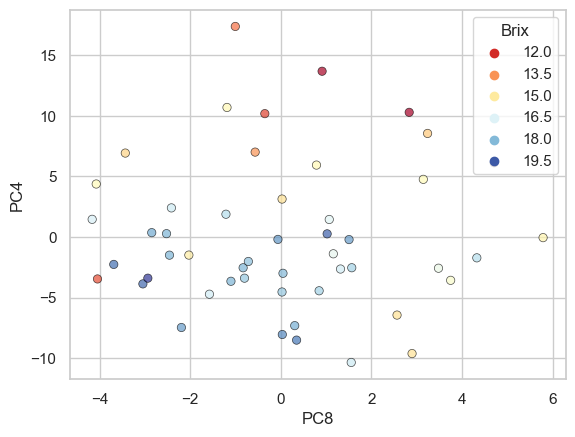

In [36]:
g=sns.scatterplot(data=scores_df, x='PC8',y='PC4', hue='Brix',
                palette = 'RdYlBu', edgecolor="black", linewidth=0.5, alpha=0.7)


### Loading Plot PC4 and PC8

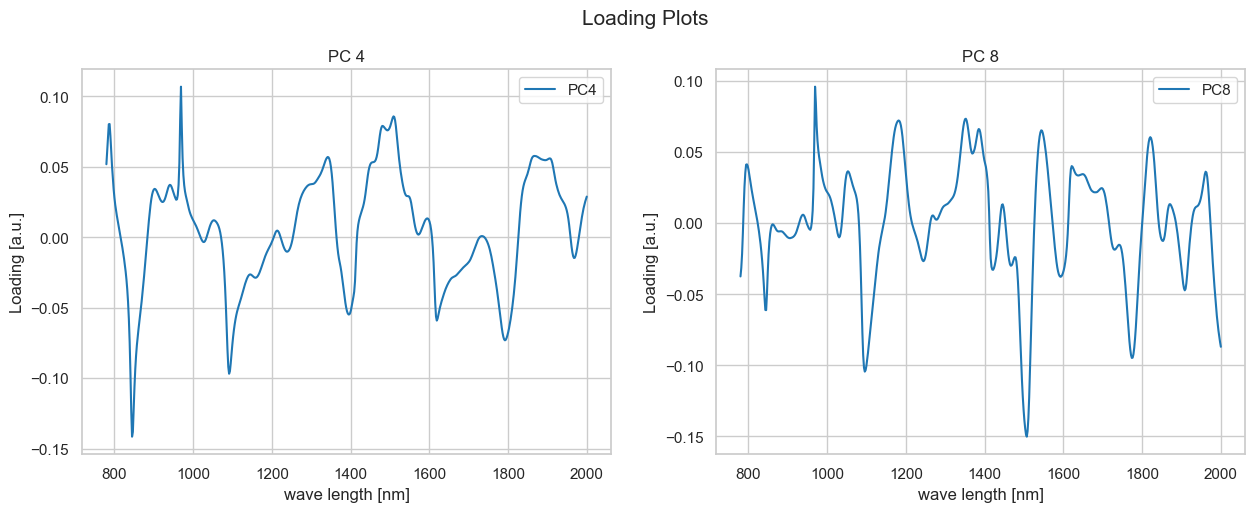

In [37]:
fig,(ax1,ax2)=plt.subplots(ncols=2, figsize=(15,5))
for ax, PC in zip([ax1,ax2], [4,8]):
    ax.plot(Wavenumber, loadings_df.iloc[:,PC-1], label='PC'+str(PC))

    ax.set_xlabel('wave length [nm]')
    ax.set_ylabel('Loading [a.u.]')
    ax.set(title=f"PC {PC}")
    ax.legend()
plt.suptitle('Loading Plots', y=1.0, fontsize=15)
plt.show()

- PC4 has a high influence at approx. 800 nm 1000nm, and 1100 nm 
- PC8 has a high influence at approx. 1000 nm, 1100 nm and 1500 nm

### PCA-R
#### Regression Model

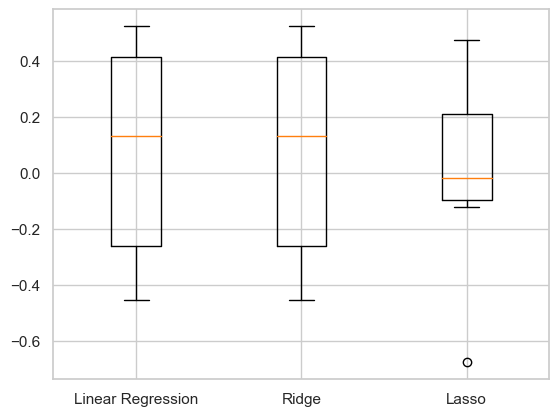

In [39]:
#Create X und y with X=Features and y=Target
df_reg = scores_df.loc[:,['PC4', 'PC8']]

X=df_reg.values
y = Brix_.Brix.values

#Split data in Train and Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, )

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(), "Lasso": Lasso()}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

#### Classification Model

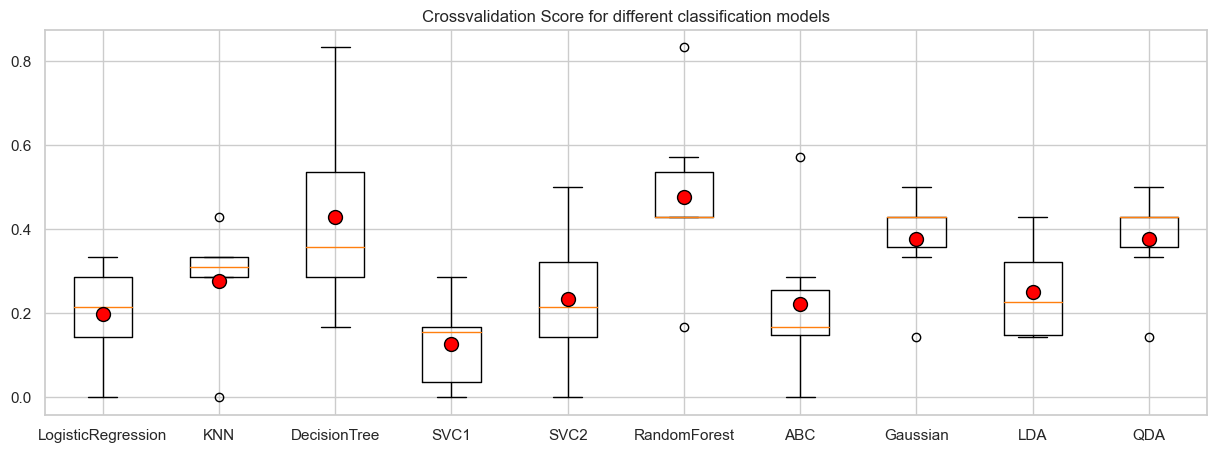

In [40]:
#Creating Brix groups for following visualisations
range=[11,14.5,16.2,17.5,18.2,np.inf]
cat_name=['11-14.5', '14.5-16.2', '16.2-17.5', '17.5-18.2', '18.2+']
Brix_['Cat']=pd.cut(Brix_['Brix'], bins=range, labels=cat_name)

#Create X und y with X=Features and y=Target
df_reg = scores_df.loc[:,['PC4', 'PC8']]
X=df_reg
y = Brix_.Cat

#Split data in Train and Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=44, stratify=y)


models={'LogisticRegression': LogisticRegression(solver='liblinear'),
        'KNN':KNeighborsClassifier(6), 
        'DecisionTree': DecisionTreeClassifier(max_depth=5), 
        'SVC1':SVC(kernel="linear", C=0.025),
        'SVC2':SVC(gamma=2, C=1),
        'RandomForest':RandomForestClassifier(),
        'ABC':AdaBoostClassifier(),
        'Gaussian': GaussianNB(),
        'LDA':LinearDiscriminantAnalysis(),
        'QDA':QuadraticDiscriminantAnalysis()
        }
results=[]
for model in models.values():
    kf=KFold(n_splits=6, shuffle=True,random_state=42)
    cv_result=cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_result)

# Create a box plot of the results
fig,ax=plt.subplots(figsize=(15,5))
plt.boxplot(results, labels=models.keys(), showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title('Crossvalidation Score for different classification models')
plt.show()

#### Test the model with the best Crossvalidation Score: DecisionTree

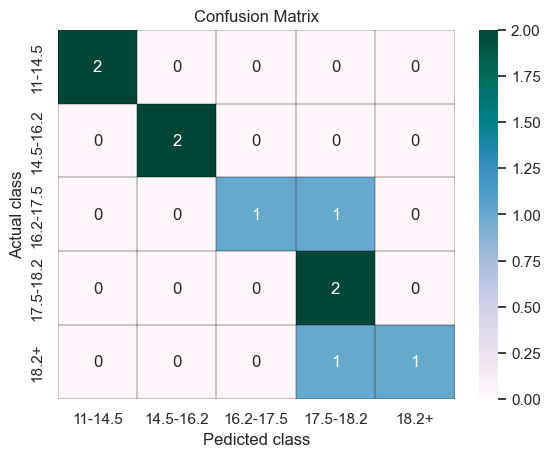

In [41]:
reg = DecisionTreeClassifier(max_depth=5)
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)

con_mat=confusion_matrix(y_test, y_pred)
con_mat_df =pd.DataFrame(con_mat, columns=(str(i) for i in cat_name),
                                index=(str(i) for i in cat_name))
fig,ax=plt.subplots()
sns.heatmap(con_mat_df,  cmap='PuBuGn', annot=True, ax=ax)
ax.set(xlabel='Pedicted class', ylabel='Actual class', title='Confusion Matrix')

for i in np.arange(0,7):
    plt.axvline(x = i, linestyle = "-", alpha = .2, color = "black")
    plt.axhline(y = i, linestyle = "-", alpha = .2, color = "black")
plt.show()

### Conclusion from PCA-R
- PCA-R provides only very poor predictions. Only classification regression is somewhat suitable.

- Possibly the models could be optimised by hyperparameter tuning

## PLS

PLS r-squared with random_state A (1817) = -0.085 
PLS r-squared with random_state B (222) = 0.844 


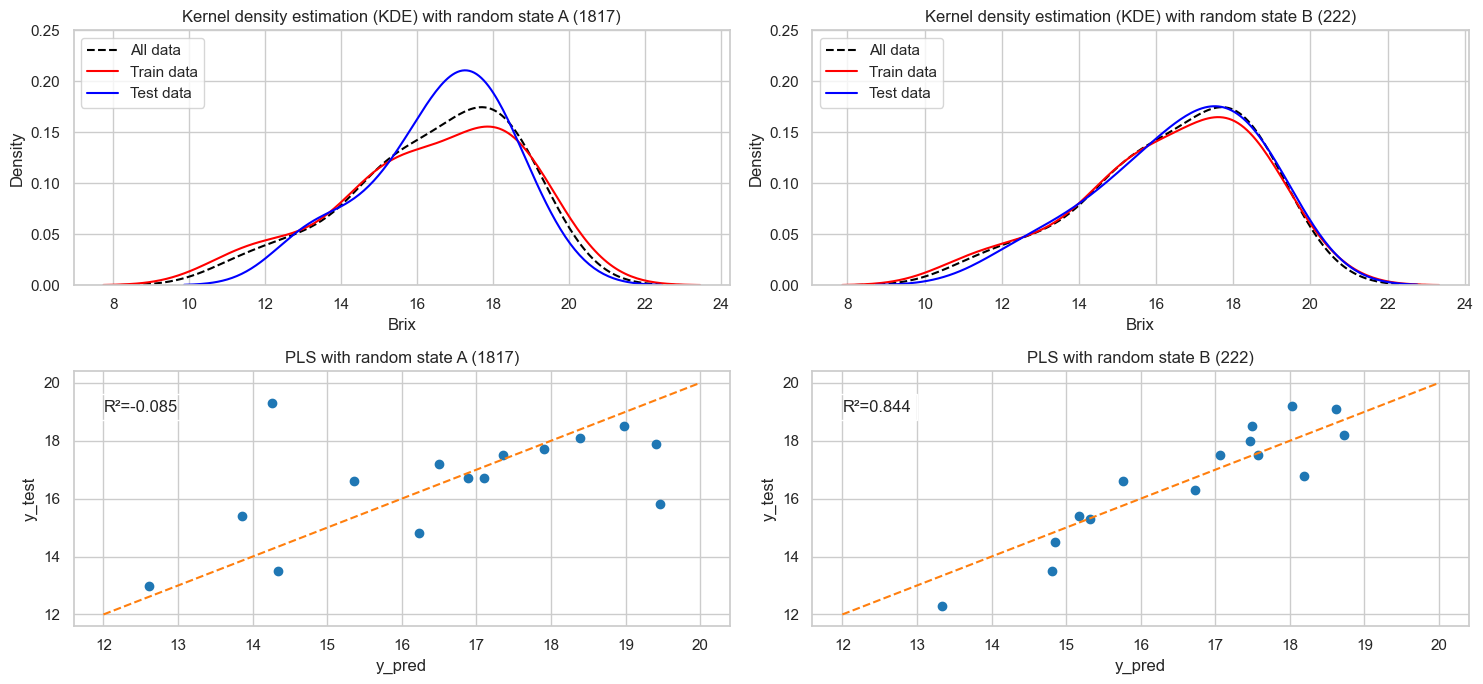

In [42]:
#Stratify Brix, because there are more Samples with a larger Brix
bins = np.linspace(11,20.01, 4)
y=Brix_['Brix']
y_binned = np.digitize(y, bins)

#Set up for visualisation
fig,((ax, ax1),(ax2,ax3))=plt.subplots(ncols=2,nrows=2, figsize=(15,7))

#Train/test split it important here, beause there are only a few samples
for num,  ax_1, ax_2, name in zip([1817,222],[ax,ax1], [ax2,ax3], ['A', 'B']):
    X_train, X_test, y_train, y_test = train_test_split(X_prepro_abl1, y, test_size=0.3, stratify=y_binned, random_state=num)
      
    sns.kdeplot(y, linestyle='--', color='black', ax=ax_1)
    sns.kdeplot(y_train, color='red', ax=ax_1)
    sns.kdeplot(y_test,color='blue', ax=ax_1)
    ax_1.set_title(f'Kernel density estimation (KDE) with random state {name} ({num})')
    ax_1.set_ylim([0, 0.25])
    ax_1.legend(['All data', 'Train data', 'Test data'], loc='upper left')
    pls = PLSRegression(n_components=3)

    pls.fit(X_train, y_train)
    score=pls.score(X_test, y_test)
    print(f"PLS r-squared with random_state {name} ({num}) = {score:.3f} ")
    y_pred = pls.predict(X_test)
    
    ax_2.plot(y_pred, y_test, 'o')
    ax_2.set(xlabel="y_pred", ylabel="y_test", title=f"PLS with random state {name} ({num})")
    ax_2.plot(np.arange(12,21), np.arange(12,21), '--')
    ax_2.text(12, 19, f'R\u00b2={score:.3f}', transform=ax_2.transData, bbox=dict(facecolor='none'))

fig.tight_layout()
plt.show()

#### Loadings - Comparison of the variance of the processed data to the loading plots 

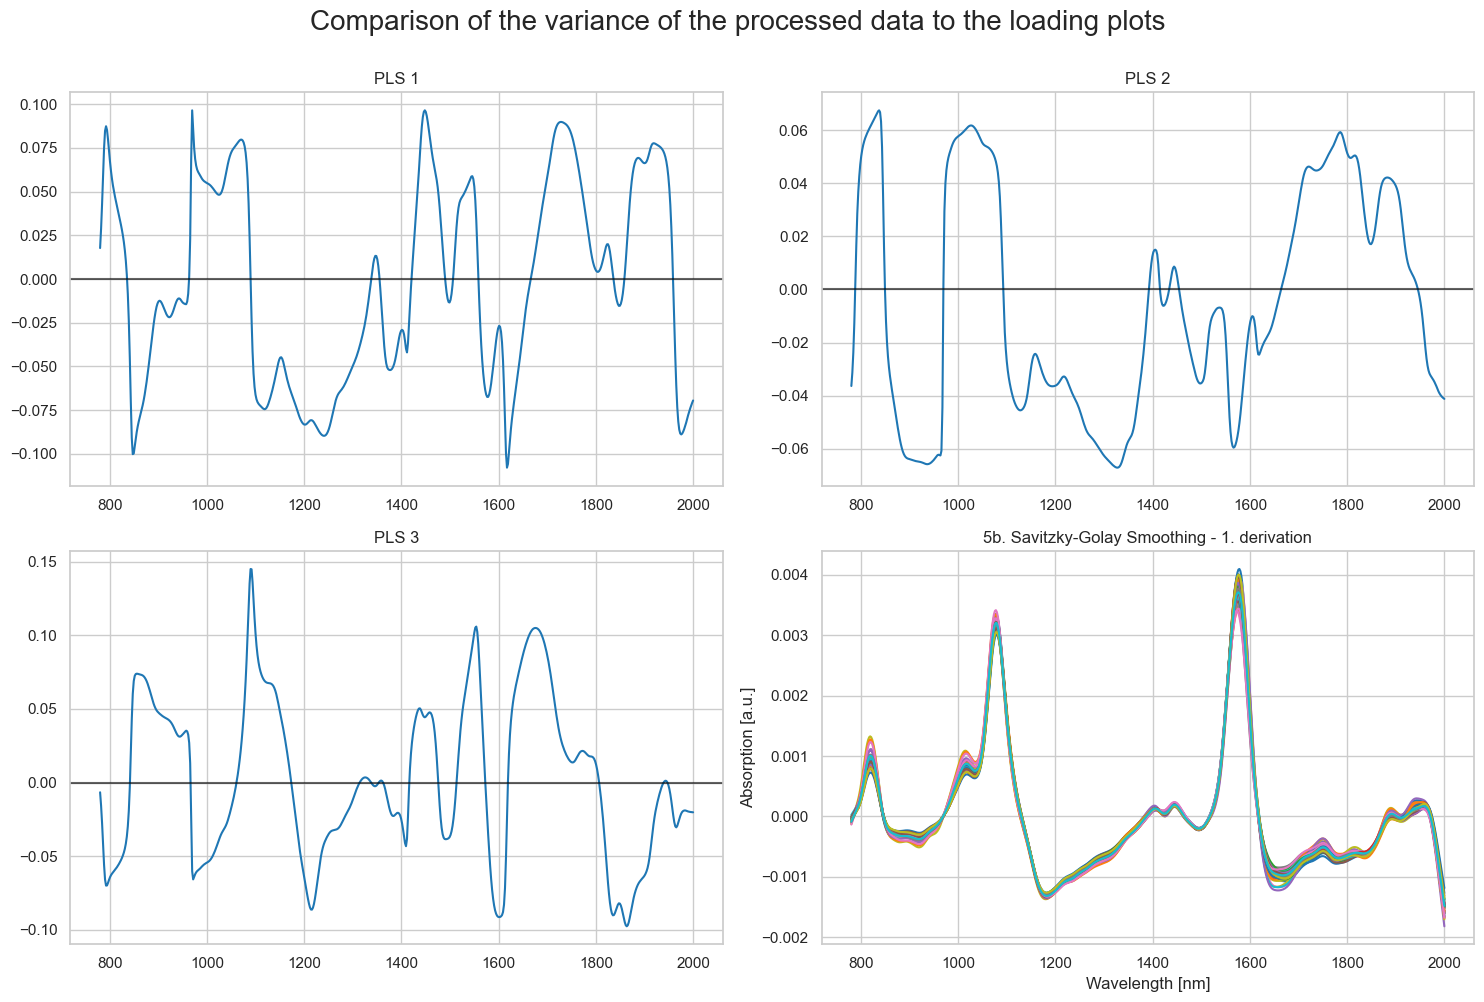

In [43]:
loadings= pls.x_loadings_
loadings=pd.DataFrame(loadings)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax1.plot(Wavenumber,loadings[0])
ax1.axhline(y = 0, linestyle = "-", alpha = .6, color = "black")
ax1.set_title('PLS 1')

ax2.plot(Wavenumber,loadings[1])
ax2.axhline(y = 0, linestyle = "-", alpha = .6, color = "black")
ax2.set_title('PLS 2')

ax3.plot(Wavenumber,loadings[2])
ax3.axhline(y = 0, linestyle = "-", alpha = .6, color = "black")
ax3.set_title('PLS 3')

plotspec(X_prepro_abl1, Wavenumber, '5b. Savitzky-Golay Smoothing - 1. derivation', ax=ax4)

plt.suptitle('Comparison of the variance of the processed data to the loading plots ', y=1.0, fontsize=20)
fig.tight_layout()

The individual PLSs have a high influence in areas where there is a high variance in the processed data (e.g. ~ 1000 nm )  
and a low influence otherwise (e.g. ~ 1400 nm).

## Discussion
- Separation of the samples according to the Brix value was done __very poorly__ and strongly dependent on the __preprocessing__. 

- Since no clear linear relationship between PCs and the Brix value could be established, regression is only possible to a limited extent.
- Separation of samples with __low Brix__ values was better than samples with high Brix values. This explains why the samples with a low Brix value were  better predicted.
<br/><br/>
- PLS delivers significantly __better predictions__ than PCA-R
- PLS performance is strongly dependent on __test/train split__. 
- The __distribution__ of the samples should correspond to the original distribution in both the test and the training data set.
- Regression model could be optimised by __hyperparameter tuning__.